In [2]:
#import required libraries - we do need the models, flatten, dense, input layers 
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [3]:
# Path for train, validation and test datasets
train_path = 'Datasets/train'
valid_path = 'Datasets/test'
test_path = 'Datasets/val' 

IMAGE_SIZE = [224, 224] #Default image size for VGG16 

folders = glob('Datasets/train/*') #Get number of classes


# ImageDataGenerator can help perform augumentation on existing images. This way, we get more diverse train set.
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

#Through flow_from_directory - we create an array of images that can be used for training. 
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('Datasets/val',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 3458 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


In [4]:
# Create a VGG16 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #Training with Imagenet weights

# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
#vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) 

# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
prediction = Dense(len(folders), activation='softmax')(x) # We have 5 classes, and so, the prediction is being done on len(folders) - 5 classes

#Creating model object 
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [6]:
#Compile the model 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history = model.fit(training_set, validation_data=validation_set, epochs=20, batch_size=32)

Epoch 1/20
55/55 [==============================] - 49s 888ms/step - loss: 0.9809 - accuracy: 0.6382 - val_loss: 0.5901 - val_accuracy: 0.7767
Epoch 2/20
55/55 [==============================] - 40s 731ms/step - loss: 0.5321 - accuracy: 0.8039 - val_loss: 0.5046 - val_accuracy: 0.8209
Epoch 3/20
55/55 [==============================] - 40s 731ms/step - loss: 0.4723 - accuracy: 0.8317 - val_loss: 0.4933 - val_accuracy: 0.8209
Epoch 4/20
55/55 [==============================] - 41s 746ms/step - loss: 0.3879 - accuracy: 0.8623 - val_loss: 0.4989 - val_accuracy: 0.8209
Epoch 5/20
55/55 [==============================] - 43s 780ms/step - loss: 0.4052 - accuracy: 0.8623 - val_loss: 0.4580 - val_accuracy: 0.8302
Epoch 6/20
55/55 [==============================] - 46s 835ms/step - loss: 0.3074 - accuracy: 0.8895 - val_loss: 0.4751 - val_accuracy: 0.8395
Epoch 7/20
55/55 [==============================] - 42s 772ms/step - loss: 0.2324 - accuracy: 0.9263 - val_loss: 0.4777 - val_accuracy: 0.8442

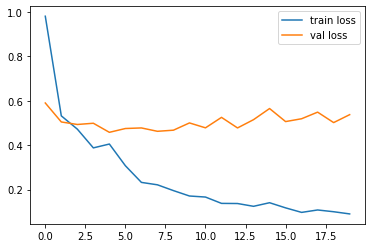

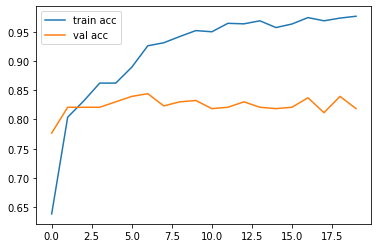

<Figure size 432x288 with 0 Axes>

In [8]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [9]:
from tensorflow.keras.models import load_model
model.save('FlowerClassification_VGG16.h5')